In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [3]:
    training_generator = ImageDataGenerator(
    rescale = 1/255, # Normalizes pixel values from 0–255 to 0–1.
    shear_range = 0.2, #Skews the image to simulate different angles.
    zoom_range = 0.2,
    horizontal_flip = True
    )
    # Load training images from directory
    training_set = training_generator.flow_from_directory('Masked/training_data',
    target_size = (64,64), #Resizes images for consistency.
    batch_size = 32,
    class_mode = 'binary' #Treats labels as 0 or 1 for two classes.
    )
    
    # Normalizes test images (no augmentation—just clean input).
    test_generator = ImageDataGenerator (rescale = 1./255)

    test_set = test_generator.flow_from_directory('Masked/test_data',
    target_size=(64,64),
    batch_size = 32,
    class_mode = 'binary'
    )

Found 492 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


In [4]:
if os.path.exists('lemon_classifier_model.h5'):
    cnn = load_model('lemon_classifier_model.h5')
    print("✅ Loaded trained model.")
else:
    cnn = tf.keras.models.Sequential()
    # 1st Convolutional layer: Detects patterns.
    cnn.add(tf.keras.layers.Conv2D(
    filters=32, # Number of feature detectors.
    kernel_size=3, #3×3 filter.
    activation='relu', #Adds non-linearity.
    input_shape=[64, 64, 3]) #For the first layer only (64×64 RGB).
    )
    # Reduces spatial dimensions (64x64 → 32x32), retaining key features.
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    # Converts 2D feature maps into a 1D vector for the classifier.
    cnn.add(tf.keras.layers.Flatten())
    # Prevents overfitting by randomly “dropping out” 40% of neurons during training.
    cnn.add(tf.keras.layers.Dropout(0.4))
    # Fully connected layer with 128 neurons for deep learning.
    cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
    # Output layer: 1 neuron gives a probability between 0 and 1.
    # sigmoid is perfect for binary classification.
    cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    cnn.compile(optimizer='adam', # Efficient gradient descent. 
    loss='binary_crossentropy', # For measuring binary classification error.
    metrics=['accuracy'] #Evaluates how many predictions were correct.
    )
    
    cnn.fit(x=training_set, validation_data=test_set, epochs=25)
    cnn.save('lemon_classifier_model.h5')
    print("✅ Trained and saved model.")

✅ Loaded trained model.


In [5]:
def predict_image(img_path): #Defines a function to load and predict a single lemon image.
    img = image.load_img(img_path, target_size=(64, 64)) #Loads and resizes image.
    img_array = image.img_to_array(img) #Converts image to numerical array.
    img_array = img_array / 255.0 #Normalize pixel values just like training data.
    img_array = np.expand_dims(img_array, axis=0) #Adds an extra dimension (batch size = 1) for prediction.
    prediction = cnn.predict(img_array)[0][0] #Gets the model’s prediction score between 0 and 1.
    print("Confidence: ", prediction) #Shows the raw confidence output from the model.
    return 'Unripened' if prediction >= 0.7 else 'Ripened' #Custom threshold: 0.7+ = Unripened lemon, else Ripened.

In [6]:
print(predict_image('predictions/image6.jpg'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Confidence:  0.17156759
Ripened


m:\Udemy\Data Analyst BootCamp\Python\Assignments\prac_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


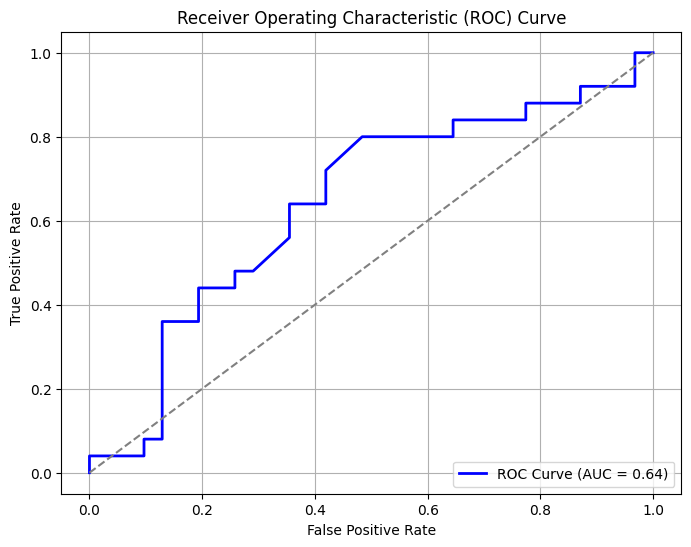

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


y_true = test_set.classes

y_pred = cnn.predict(test_set).ravel()

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
